### Name: Dmytro Vnukov

### Task: Build a model to predict forest cover type

#### About the UCI Machine Learning Cover Type Data Set
Predicting forest cover type from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types). 

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices. 

Some background information for these four wilderness areas: Neota (area 2) probably has the highest mean elevational value of the 4 wilderness areas. Rawah (area 1) and Comanche Peak (area 3) would have a lower mean elevational value, while Cache la Poudre (area 4) would have the lowest mean elevational value. 

As for primary major tree species in these areas, Neota would have spruce/fir (type 1), while Rawah and Comanche Peak would probably have lodgepole pine (type 2) as their primary species, followed by spruce/fir and aspen (type 5). Cache la Poudre would tend to have Ponderosa pine (type 3), Douglas-fir (type 6), and cottonwood/willow (type 4). 

The Rawah and Comanche Peak areas would tend to be more typical of the overall dataset than either the Neota or Cache la Poudre, due to their assortment of tree species and range of predictive variable values (elevation, etc.) Cache la Poudre would probably be more unique than the others, due to its relatively low elevation range and species composition.

#### Attribute Description
Given is the attribute name, attribute type, the measurement unit and a brief description. The forest cover type is the classification problem. The order of this listing corresponds to the order of numerals along the rows of the database. 

Name / Data Type / Measurement / Description 

    1) Elevation / quantitative /meters / Elevation in meters 
    2) Aspect / quantitative / azimuth / Aspect in degrees azimuth 
    3) Slope / quantitative / degrees / Slope in degrees 
    4) Horizontal_Distance_To_Hydrology / quantitative / meters / Horz Dist to nearest surface water features 
    5) Vertical_Distance_To_Hydrology / quantitative / meters / Vert Dist to nearest surface water features 
    6) Horizontal_Distance_To_Roadways / quantitative / meters / Horz Dist to nearest roadway 
    7) Hillshade_9am / quantitative / 0 to 255 index / Hillshade index at 9am, summer solstice 
    8) Hillshade_Noon / quantitative / 0 to 255 index / Hillshade index at noon, summer soltice 
    9) Hillshade_3pm / quantitative / 0 to 255 index / Hillshade index at 3pm, summer solstice 
    10) Horizontal_Distance_To_Fire_Points / quantitative / meters / Horz Dist to nearest wildfire ignition points 
    11) Wilderness_Area (4 binary cols) / qualitative / 0 (absence) or 1 (presence) / Wilderness area designation 
    12) Soil_Type (40 binary columns) / qualitative / 0 (absence) or 1 (presence) / Soil Type designation 
    13) Cover_Type (7 types) / integer / 1 to 7 / Forest Cover Type designation

In [21]:
# initialisation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# %config InlineBackend.figure_format = 'svg'  # improves the quality of graphs
%matplotlib inline
sns.set()

In [22]:
# create column names in the dataset
# continuous variables
cont_attributes = [ "Elevation", "Aspect", "Slope", "R_Hydrology", 
                    "Z_Hydrology", "R_Roadways", "Hillshade_9am", 
                    "Hillshade_Noon", "Hillshade_3pm", "R_Fire_Points" ]

# categorical variables
cont_dict = {attribute: np.float64 for attribute in cont_attributes}
area_attributes = ['Wild_Area_' + str(i + 1) for i in range(4)]
area_dict = {attribute: np.int64 for attribute in area_attributes}
soil_attributes = ['Soil_Type' + str(i + 1) for i in range(40)]
soil_dict = {attribute: np.int64 for attribute in soil_attributes}
cat_attributes = area_attributes + soil_attributes

target = 'Cover_Type'  # we aim to predict

attributes = cont_attributes + cat_attributes  # all column names except target
dtypes_dict = {**cont_dict, **area_dict, **soil_dict}

In [23]:
# load dataset
data = pd.read_csv('covtype.data', header=None, names=attributes + [target], dtype=dtypes_dict)

# Dataset Overview

In [5]:
print(data.shape)  # print number of (rows, columns) 

(581012, 55)


In [6]:
data.head()[cont_attributes]

,Elevation,Aspect,Slope,R_Hydrology,Z_Hydrology,R_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,R_Fire_Points
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0


In [7]:
data.describe()[cont_attributes]

,Elevation,Aspect,Slope,R_Hydrology,Z_Hydrology,R_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,R_Fire_Points
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000



cover type percentage distribution:


,percentage
2,48.759922
1,36.460521
3,6.153746
7,3.530048
6,2.989095
5,1.633873
4,0.472796


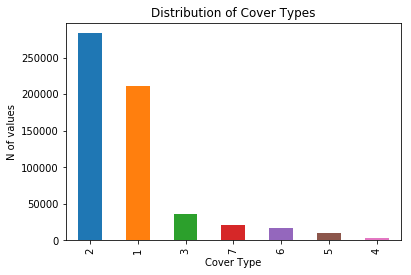

In [8]:
# class distribution

print()
print("cover type percentage distribution:")
series = 100 * data['Cover_Type'].value_counts() / data['Cover_Type'].count()

ax = data.Cover_Type.value_counts().plot(kind='bar')
ax.set(xlabel='Cover Type', ylabel='N of values',
       title='Distribution of Cover Types')

pd.DataFrame({'percentage': series})

We have 7 classes out of which 2 classes (cover type 1 and 2) form 85% of the data. There are 2 classes (cover type 4 and 5) with less than 2% representation. Therefore, the dataset is heavily skewed, and this should be accounted for when creating a model.

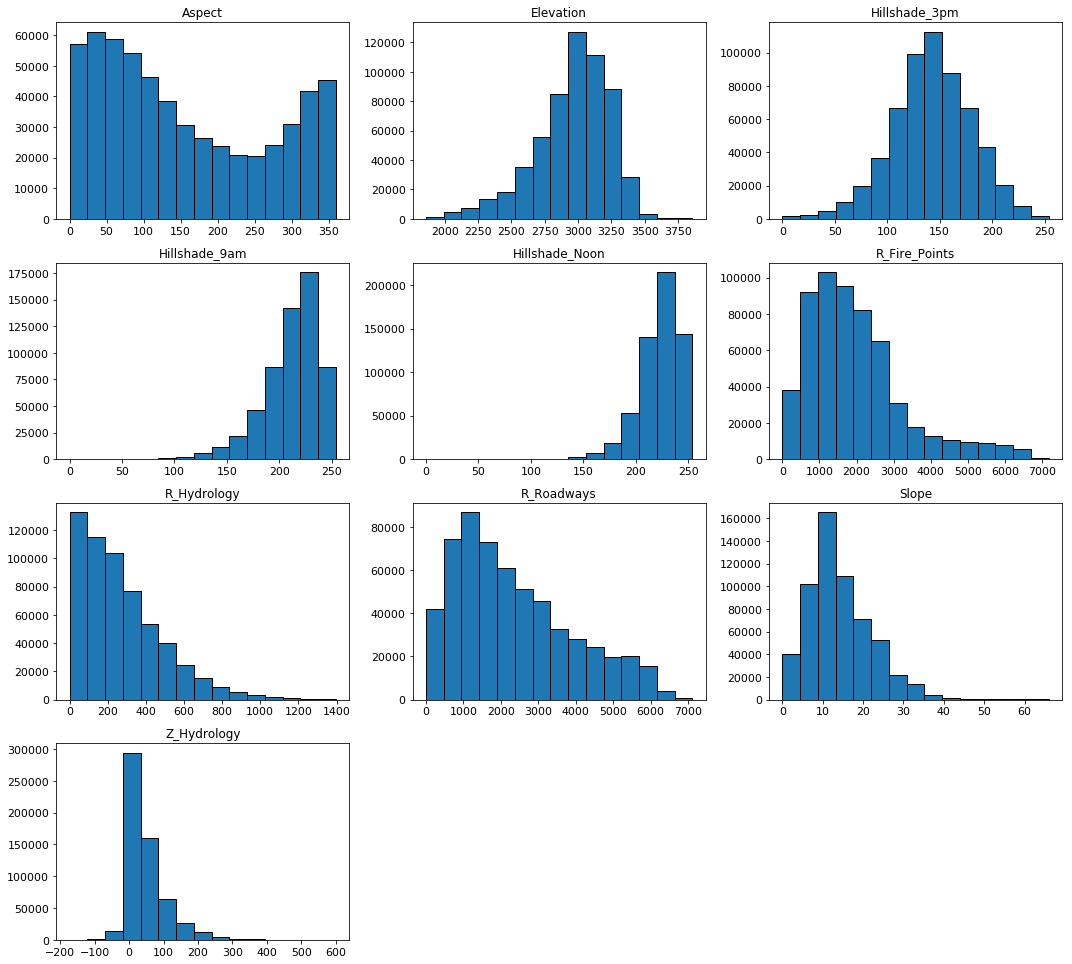

In [9]:
fig = data[cont_attributes].hist(bins=15, edgecolor='black', linewidth=1.0, 
                            xlabelsize=11, ylabelsize=11, figsize=(10, 9),
                            grid=False)

plt.tight_layout(rect=(0, 0, 1.5, 1.5))

From the visual analysis of the graphs, it is possible to see that all of the data is not normally distributed, apart from the Hillshade_3pm which looks most normally distributed. Most of the data is skewed. In the case of R_Fire_Points, R_Hydrology and R_Roadways, we can see that a large part of the distribution is located far from the largest part of the sample. Also, Aspect attribute looks bimodal with the largest parts of the distribution positioned on the edges of the distribution.

# Correlation between variables

Text(0.5, 0.98, 'Correlation Heatmap of Attributes in Cover Type Dataset')

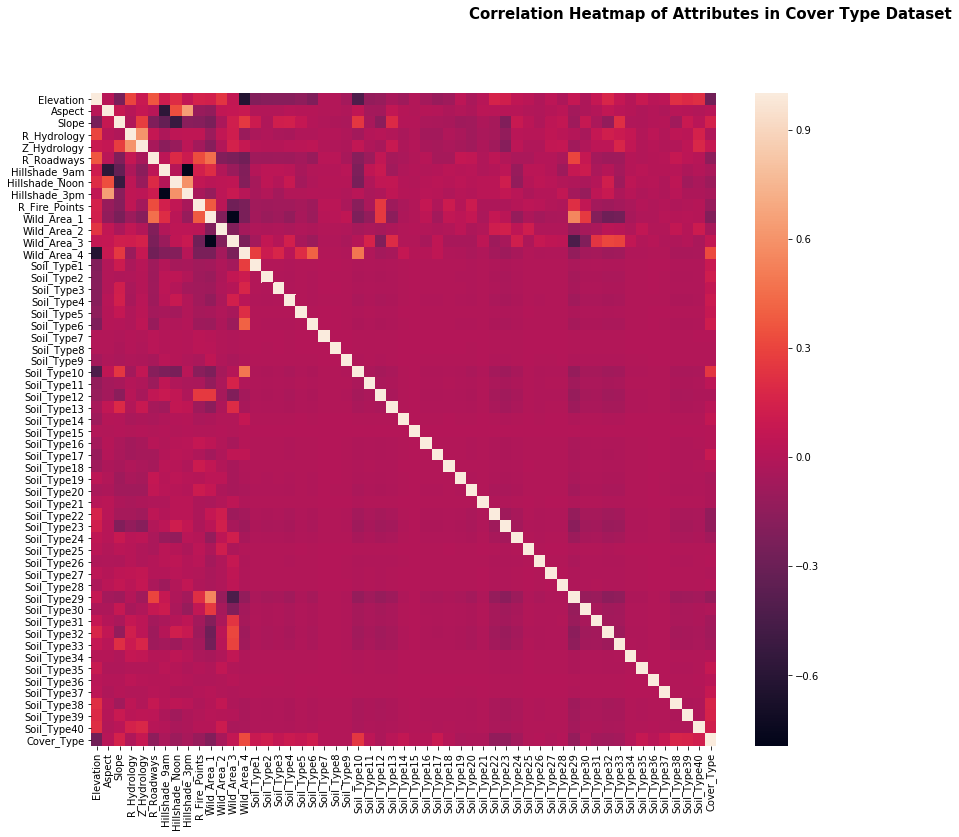

In [10]:
# correlation matrix

corrmat = data.corr();
fig, ax = plt.subplots(figsize=(14, 12));
sns.heatmap(corrmat);
fig.suptitle('Correlation Heatmap of Attributes in Cover Type Dataset', 
             fontsize=15, fontweight='bold', ha='left');

From the heatmap above, we see that very few variables have any significant correlation. Most of the relationships could be spotted between continuous variables and also we can see that continuous variables have some little correlation with categorical variables. Also, we can see that categorical variables have very little correlation among each other, although, some of the variables show small negative correlation, for example, between soil_type 10-14 and soil_type 29-33.

In [11]:
# most correlated variables
size = len(data.columns)
corr_list = []
for i in range(size):
    for j in range(i+1, size):
        cc = corrmat.iloc[i, j]
        if abs(cc) > 0.5:
            corr_list.append((cc, i, j))

corr_list.sort(key=(lambda x: abs(x[0])), reverse=True)
[(cc, attributes[i], attributes[j]) for cc, i, j in corr_list]

[(-0.7935926588245623, 'Wild_Area_1', 'Wild_Area_3'),
 (-0.7802959522805725, 'Hillshade_9am', 'Hillshade_3pm'),
 (0.6469439534956581, 'Aspect', 'Hillshade_3pm'),
 (-0.6193739227919234, 'Elevation', 'Wild_Area_4'),
 (0.606235505958923, 'R_Hydrology', 'Z_Hydrology'),
 (0.5942736480373546, 'Hillshade_Noon', 'Hillshade_3pm'),
 (-0.5792729109405548, 'Aspect', 'Hillshade_9am'),
 (0.5505492447251936, 'Wild_Area_1', 'Soil_Type29'),
 (-0.5269106396630941, 'Slope', 'Hillshade_Noon')]

So we have 9 variables that have high level of correlation (more than 0.5).

Creating scatterplot using only continuous variables.

/Users/Dimasik007/anaconda3/envs/nplant_task/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


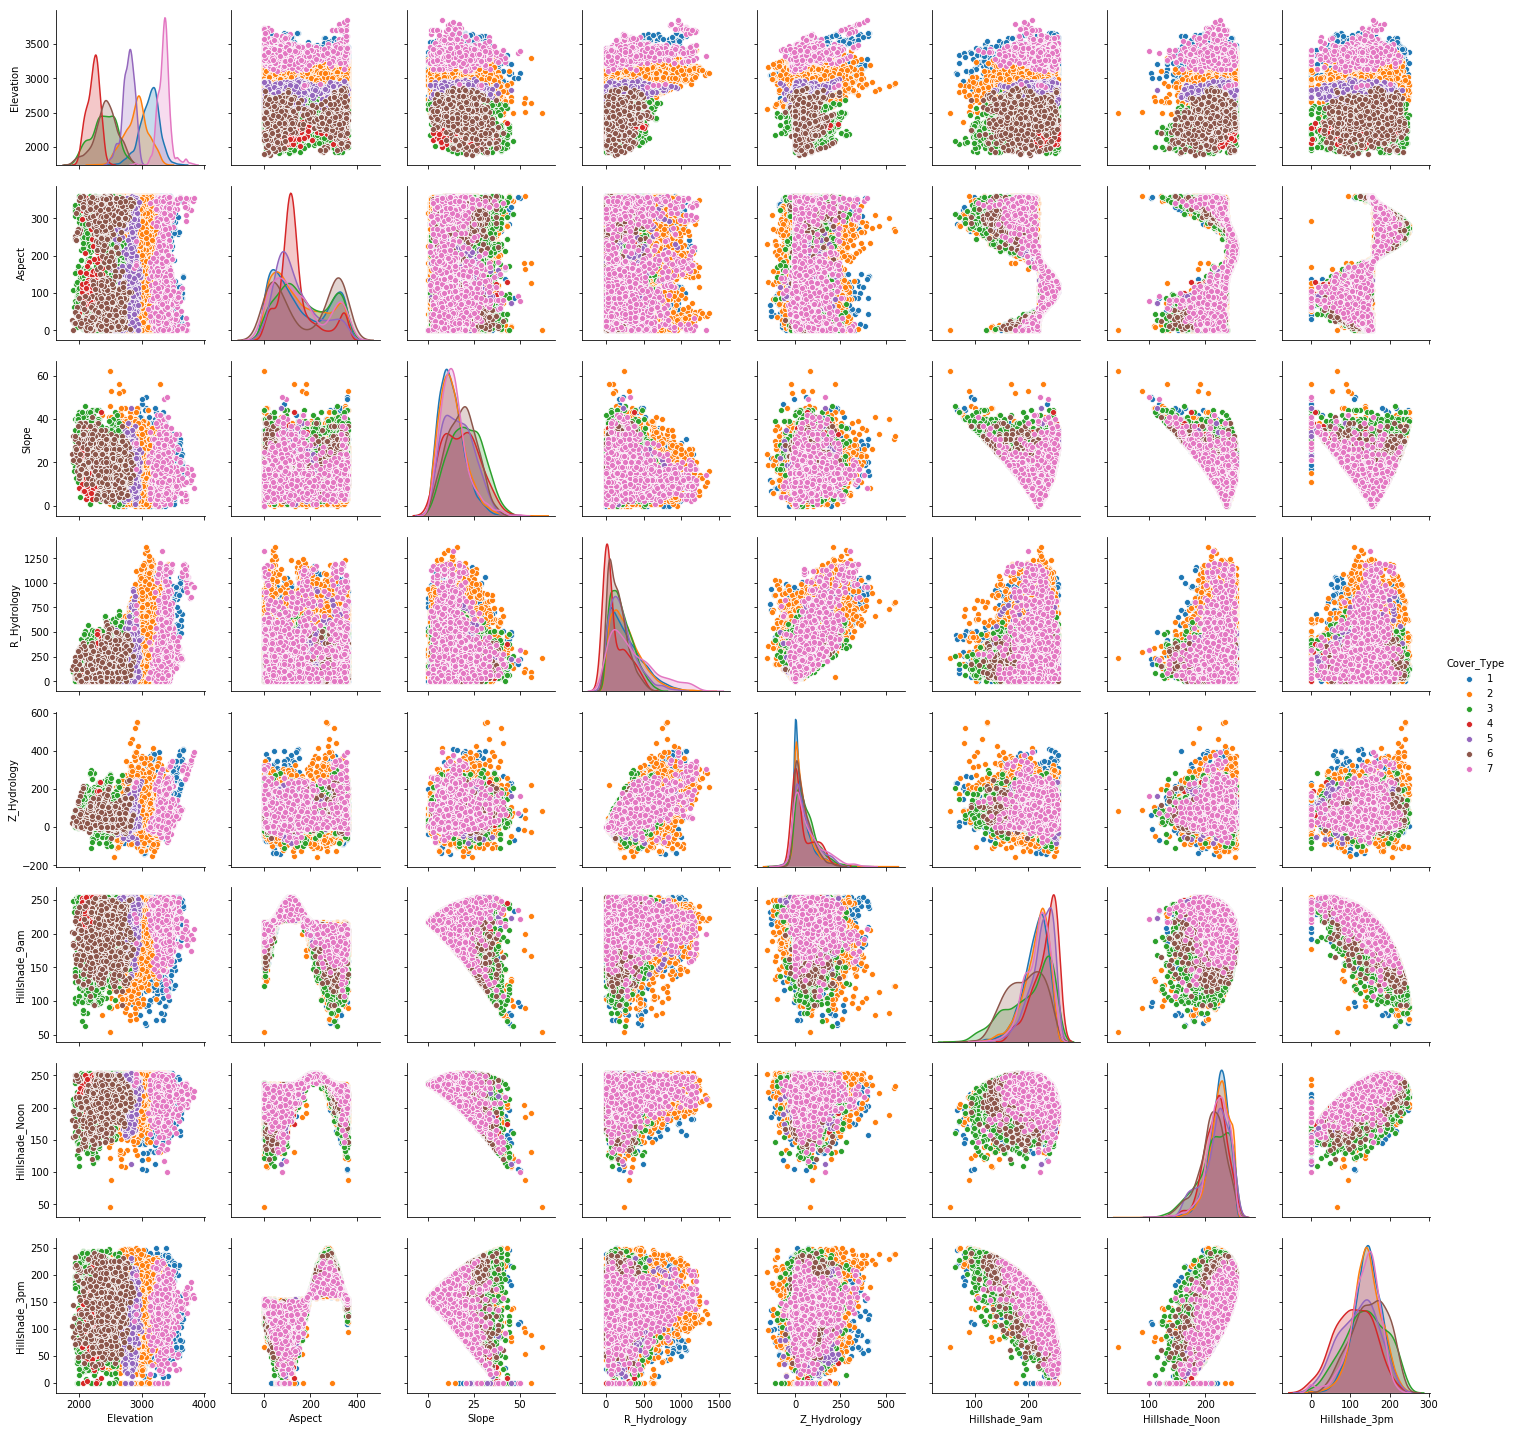

In [12]:
datvis = data.sample(frac=0.05)  # getting random 5% sample of dataset for visualisation

# visualising correlated variables in a scatterplot
g = sns.pairplot(datvis, vars=['Elevation', 'Aspect', 'Slope', 'R_Hydrology', 'Z_Hydrology',
                               'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'],
                 hue='Cover_Type');

From the histograms on the diagonal, we can see that all of the classes follow the same distribution, apart from the case of Elevation attribute in which different cover types have different distributions.

In [13]:
def normalise(x):
    """ standardize features by removing the mean and scaling to unit variance """
    scaler = StandardScaler()
    x_norm = scaler.fit_transform(x.values)
    x_norm = pd.DataFrame(x_norm, index=x.index, columns=x.columns)
    print("normalised data {}".format(x_norm.shape))
    return x_norm

Lets select a sample of the data to train the Support Vector Machine Classifier and validate that the sample is representative of the data. SVC tends to show great results in the classification problems, although, it doesn't scale well to train on too many samples, so it is reasonable to select a sample of 15,000. 


cover type percentage distribution:


,percentage
2,49.406667
1,36.266667
3,5.986667
7,3.420000
6,2.880000
5,1.653333
4,0.386667


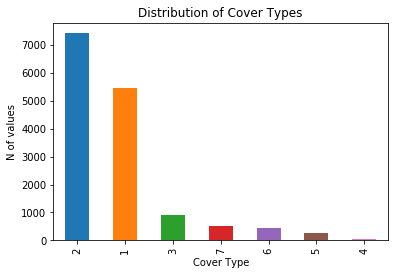

In [18]:
train_test_data = data.sample(n=15000)

print()  # validate that we have proper sample of the dataset
print("cover type percentage distribution:")
series = 100 * train_test_data['Cover_Type'].value_counts() / train_test_data['Cover_Type'].count()

ax = train_test_data.Cover_Type.value_counts().plot(kind='bar')
ax.set(xlabel='Cover Type', ylabel='N of values',
       title='Distribution of Cover Types')

pd.DataFrame({'percentage': series})

In [19]:
train_test_data.describe()

,Elevation,Aspect,Slope,R_Hydrology,Z_Hydrology,R_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,R_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,2960.105000,156.239400,14.065933,267.471267,46.068267,2369.747800,211.981467,223.428733,142.881533,1987.160200,...,0.090867,0.075200,0.003133,0.002667,0.000600,0.000533,0.024667,0.021733,0.015133,2.040733
std,278.383097,112.171802,7.468090,211.546767,58.163371,1560.044839,26.946407,19.625655,38.265379,1340.795247,...,0.287429,0.263723,0.055890,0.051573,0.024488,0.023089,0.155112,0.145816,0.122087,1.378792
min,1920.000000,0.000000,0.000000,0.000000,-158.000000,0.000000,64.000000,101.000000,0.000000,42.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2810.000000,59.000000,9.000000,108.000000,7.000000,1132.000000,198.000000,213.000000,120.000000,1019.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2997.000000,126.000000,13.000000,216.000000,29.000000,2014.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3164.000000,260.000000,18.000000,384.000000,68.000000,3353.000000,231.000000,237.000000,168.000000,2561.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3857.000000,360.000000,49.000000,1319.000000,590.000000,7117.000000,254.000000,254.000000,252.000000,7081.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [20]:
train_test_data.head()

,Elevation,Aspect,Slope,R_Hydrology,Z_Hydrology,R_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,R_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
76391,2998.0,14.0,6.0,295.0,-5.0,5117.0,215.0,228.0,150.0,4583.0,...,0,0,0,0,0,0,0,0,0,2
26960,2773.0,82.0,2.0,150.0,15.0,2621.0,221.0,236.0,151.0,6139.0,...,0,0,0,0,0,0,0,0,0,2
382036,3188.0,306.0,8.0,331.0,13.0,631.0,197.0,235.0,178.0,1159.0,...,0,0,0,0,0,0,0,0,0,2
505780,3205.0,21.0,10.0,631.0,88.0,977.0,214.0,219.0,141.0,2110.0,...,0,0,0,0,0,0,0,0,0,1
551168,2935.0,153.0,18.0,210.0,-1.0,3327.0,239.0,238.0,122.0,1262.0,...,0,0,0,0,0,0,0,0,0,2


In [21]:
# drop sample data from original dataset and create validation dataset

validation_data = data.drop(train_test_data.index)
validation_data.describe()

,Elevation,Aspect,Slope,R_Hydrology,Z_Hydrology,R_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,R_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,566012.000000,566012.000000,566012.000000,566012.000000,566012.000000,566012.000000,566012.000000,566012.000000,566012.000000,566012.000000,...,566012.000000,566012.000000,566012.000000,566012.000000,566012.000000,566012.000000,566012.000000,566012.000000,566012.000000,566012.000000
mean,2959.345698,155.641368,14.104704,269.480078,46.428146,2349.627156,212.150410,223.315801,142.518901,1980.109190,...,0.090380,0.077783,0.002763,0.003270,0.000194,0.000512,0.026860,0.023816,0.015058,2.051755
std,280.027273,111.906932,7.488779,212.575802,58.298745,1559.231957,26.765205,19.772483,38.274761,1323.753171,...,0.286725,0.267830,0.052493,0.057093,0.013939,0.022630,0.161674,0.152475,0.121784,1.396971
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1104.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3327.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7116.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [22]:
# SVC
# create training, testing and validation datasets
# normalise data to improve accuracy and training speed
y = train_test_data[target]
X = train_test_data[attributes]
X = normalise(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)
X_val = validation_data[attributes]
y_val = validation_data[target]
X_val = normalise(X_val)

normalised data (15000, 54)
normalised data (566012, 54)


In [23]:
# specify parameters of the SVC that we want to try
svc_parameters = [
    {'kernel': ['poly'], 'degree': [2, 3, 4], 'C': [1, 1000], 'gamma': [0.001, 0.01, 0.1]},
    {'kernel': ['rbf'], 'C': [1, 1000], 'gamma': [0.0001, 0.1, 1]},
    {'kernel': ['linear'], 'C': [1, 100, 1000]} ]

# define the SVC classifier, use cross validation of 4 (stratified K-fold)
clf = GridSearchCV( SVC( class_weight='balanced', cache_size=400 ),
                    param_grid=svc_parameters, cv=4, scoring='accuracy', n_jobs=-1, refit=True,
                    return_train_score=False, verbose=42 )

clf.fit(X_train, y_train)  # train the classifier


Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=400, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'kernel': ['poly'], 'degree': [2, 3, 4], 'C': [1, 1000], 'gamma': [0.001, 0.01, 0.1]}, {'kernel': ['rbf'], 'C': [1, 1000], 'gamma': [0.0001, 0.1, 1]}, {'kernel': ['linear'], 'C': [1, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=42)

In [25]:
# print training results
print( "RESULTS on TRAINING dataset" )
print( "Accuracy on training data {0:0.2f} %".format( clf.score( X_train, y_train ) ) )
print( "Best parameters set found on training dataset:" )
print( clf.best_params_ )
print()
print( "Grid scores on training set:" )
means = clf.cv_results_[ 'mean_test_score' ]
stds = clf.cv_results_[ 'std_test_score' ]
for mean, std, params in zip( means, stds, clf.cv_results_[ 'params' ] ):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

RESULTS on TRAINING dataset
Accuracy on training data 0.88 %
Best parameters set found on development set:
{'C': 1, 'degree': 4, 'gamma': 0.1, 'kernel': 'poly'}

Grid scores on training set:
0.521 (+/-0.070) for {'C': 1, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}
0.560 (+/-0.013) for {'C': 1, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
0.681 (+/-0.005) for {'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
0.030 (+/-0.007) for {'C': 1, 'degree': 3, 'gamma': 0.001, 'kernel': 'poly'}
0.520 (+/-0.025) for {'C': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
0.724 (+/-0.015) for {'C': 1, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
0.020 (+/-0.003) for {'C': 1, 'degree': 4, 'gamma': 0.001, 'kernel': 'poly'}
0.554 (+/-0.126) for {'C': 1, 'degree': 4, 'gamma': 0.01, 'kernel': 'poly'}
0.742 (+/-0.007) for {'C': 1, 'degree': 4, 'gamma': 0.1, 'kernel': 'poly'}
0.604 (+/-0.008) for {'C': 1000, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}
0.701 (+/-0.019) for {'C': 1000, 'degree': 2,

Training Support Vector Machine Classifier and trying different hyperparameters with stratified K-fold cross-validation took 22 minutes and the parameters giving the best accuracy score were found. Grid scores show the performance of the classifier with different parameters and could be used for further parameter tuning to achieve better accuracy.

SVC was chosen because it works well in high dimensional space, relatively easy to optimise, it gives global optimal solution and it tends to show high levels of accuracy on classification problems. The downside is that it doesn't scale well to a large number of samples in the training dataset, although, once training is finished, SVC classifies large datasets quickly.

In [27]:
# predict testing dataset and print results
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
target_names = ['Cover Type 1', 'Cover Type 2', 'Cover Type 3', 'Cover Type 4',
               'Cover Type 5', 'Cover Type 6', 'Cover Type 7']
print( "RESULTS on TESTING dataset" )
print()
print('Support Vector Machine Classifier\n {}\n'.format(classification_report( y_test, y_pred,
                                                                               target_names=target_names ) ) )
print("Accuracy Score: {0:0.2f} %".format(acc * 100))
print()
print( "Best Estimator: " )
print(clf.best_estimator_)

RESULTS on TESTING dataset

Support Vector Machine Classifier
               precision    recall  f1-score   support

Cover Type 1       0.75      0.78      0.76      2158
Cover Type 2       0.82      0.78      0.80      2953
Cover Type 3       0.77      0.70      0.73       376
Cover Type 4       0.50      0.39      0.44        23
Cover Type 5       0.30      0.50      0.37       107
Cover Type 6       0.49      0.56      0.52       170
Cover Type 7       0.72      0.74      0.73       213

   micro avg       0.76      0.76      0.76      6000
   macro avg       0.62      0.63      0.62      6000
weighted avg       0.77      0.76      0.76      6000


Accuracy Score: 75.97 %

Best Estimator: 
SVC(C=1, cache_size=400, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=4, gamma=0.1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [28]:
# predict validation set
y_pred2 = clf.predict( X_val )
acc2 = accuracy_score(y_val, y_pred2)
target_names = ['Cover Type 1', 'Cover Type 2', 'Cover Type 3', 'Cover Type 4',
                'Cover Type 5', 'Cover Type 6', 'Cover Type 7']
print('Support Vector Machine Classifier\n {}\n'.format(classification_report( y_val, y_pred2,
                                                                               target_names=target_names ) ) )
print("Accuracy Score: {0:0.2f} %".format(acc2 * 100))

Support Vector Machine Classifier
               precision    recall  f1-score   support

Cover Type 1       0.74      0.77      0.76    206400
Cover Type 2       0.81      0.77      0.79    275890
Cover Type 3       0.74      0.70      0.72     34856
Cover Type 4       0.54      0.44      0.49      2689
Cover Type 5       0.27      0.49      0.35      9245
Cover Type 6       0.50      0.54      0.52     16935
Cover Type 7       0.68      0.72      0.70     19997

   micro avg       0.75      0.75      0.75    566012
   macro avg       0.61      0.63      0.62    566012
weighted avg       0.76      0.75      0.75    566012


Accuracy Score: 74.77 %


SVC was trained and tested on ~2.5% of the data (15000 samples). ~97.5% of the data were used for validation and classifier achieved nearly 75% accuracy, although, it could be seen that f1 score is low on Cover Types 4, 5 and 6 due to the fact, that there are much fewer samples of those classes. This problem could be solved by bringing more samples of those classes to the training dataset or manually putting more weight on those classes when defining the SVC.

In [17]:
# train Random Forest Classifier on 60% of the data, 
# tune hyper parameters with Randomised search and CV of 4

y = data[target]
X = data[attributes]
print(y.shape)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4 )

n_estimators = [int(x) for x in np.linspace(start = 20, stop = 60, num = 10)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# specify parameters of the SVC that we want to try
rf_parameters = {'n_estimators': n_estimators,
                 'min_samples_split': min_samples_split, 
                 'min_samples_leaf': min_samples_leaf, 
                 'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_tuned = RandomizedSearchCV(estimator=rf, param_distributions=rf_parameters,
                        n_iter=10, cv=4, verbose=42, n_jobs=-1)

rf_tuned.fit(X_train, y_train)

(581012,)
(581012, 54)
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  2

RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [20, 24, 28, 33, 37, 42, 46, 51, 55, 60], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=42)

In [18]:
# print training results
print( "RESULTS on TRAINING dataset:" )
print( "Accuracy on training data {0:0.2f} %".format( rf_tuned.score( X_train, y_train ) ) )
print( "Best parameters set found on training dataset:" )
print( rf_tuned.best_params_ )
print()
print( "Grid scores on training set:" )
means = rf_tuned.cv_results_[ 'mean_test_score' ]
stds = rf_tuned.cv_results_[ 'std_test_score' ]
for mean, std, params in zip( means, stds, rf_tuned.cv_results_[ 'params' ] ):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

RESULTS on TRAINING dataset:
Accuracy on training data 1.00 %
Best parameters set found on training dataset:
{'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False}

Grid scores on training set:
0.940 (+/-0.003) for {'n_estimators': 24, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False}
0.940 (+/-0.001) for {'n_estimators': 37, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': False}
0.941 (+/-0.001) for {'n_estimators': 51, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': False}
0.943 (+/-0.002) for {'n_estimators': 24, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}
0.933 (+/-0.003) for {'n_estimators': 55, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': False}
0.947 (+/-0.003) for {'n_estimators': 42, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False}
0.944 (+/-0.001) for {'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False}
0.938 (

In [19]:
# predict testing set
y_pred2 = rf_tuned.predict(X_test)
acc2 = accuracy_score(y_test, y_pred2)
target_names = ['Cover Type 1', 'Cover Type 2', 'Cover Type 3', 'Cover Type 4',
               'Cover Type 5', 'Cover Type 6', 'Cover Type 7']
print( "RESULTS on TESTING dataset:" )
print('Random Forest Classifier\n {}\n'.format(classification_report( y_test, y_pred2,
                                                                               target_names=target_names )))
print("Accuracy Score: {0:0.2f} %".format(acc2 * 100))

RESULTS on TESTING dataset:
Random Forest Classifier
               precision    recall  f1-score   support

Cover Type 1       0.96      0.95      0.95     84697
Cover Type 2       0.95      0.97      0.96    113260
Cover Type 3       0.94      0.96      0.95     14484
Cover Type 4       0.93      0.84      0.89      1090
Cover Type 5       0.94      0.78      0.85      3840
Cover Type 6       0.93      0.90      0.91      6929
Cover Type 7       0.97      0.95      0.96      8105

   micro avg       0.96      0.96      0.96    232405
   macro avg       0.95      0.91      0.93    232405
weighted avg       0.96      0.96      0.95    232405


Accuracy Score: 95.51 %


The Random Forest model showed more than 95% in classification accuracy. The model also showed a lower F1 score on the least represented Cover Type classes. Training took only several minutes and so was much faster than in the case of SVC. The model showing best performance had 60 trees and the more trees there are and the higher the depth of the trees, the more time it takes to classify a single sample. However, the classification still happens very quickly in our case.

Overall, the random forest classifier showed excellent classification performance and was the best model. The model could be improved further by searching over a larger parameter space, although, this would increase the training time.